# Physics-Informed Neural Networks (PINNs)

**Learning Objectives:**
- Understand why standard neural networks fail for physics problems
- Learn how to incorporate physics into neural network training
- Master automatic differentiation for computing derivatives
- Compare data-driven vs physics-informed approaches

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/ut-portugal-sciml/blob/main/docs/01-pinn/pinn.ipynb)

## The Problem: A Damped Harmonic Oscillator

We begin with a concrete problem that everyone understands: a mass on a spring with damping. This is the perfect starting point because:

1. **Physical intuition**: Everyone knows how springs work
2. **Mathematical tractability**: We have an exact solution
3. **Clear demonstration**: Shows why standard ML fails and PINNs succeed

### The Physical System

![Harmonic Oscillator](figs/harmonic-oscillator.png)

A mass $m$ attached to a spring (constant $k$) with damping (coefficient $c$). The displacement $u(t)$ from equilibrium satisfies:

$$m \frac{d^2 u}{dt^2} + c \frac{du}{dt} + ku = 0$$

**Initial conditions:** $u(0) = 1$, $\frac{du}{dt}(0) = 0$ (starts at rest, displaced)

**Parameters:** $m = 1$, $c = 4$, $k = 400$ (underdamped: $c^2 < 4mk$)

### The Exact Solution

For underdamped motion ($\delta < \omega_0$ where $\delta = c/(2m)$ and $\omega_0 = \sqrt{k/m}$):

$$u(t) = e^{-\delta t}\left(\cos(\omega t) + \frac{\delta}{\omega}\sin(\omega t)\right)$$

where $\omega = \sqrt{\omega_0^2 - \delta^2}$ is the damped frequency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Physical parameters
m = 1.0      # mass
c = 4.0      # damping coefficient  
k = 400.0    # spring constant

# Derived parameters
delta = c / (2 * m)                # damping ratio
omega_0 = np.sqrt(k / m)           # natural frequency
omega = np.sqrt(omega_0**2 - delta**2) # damped frequency

print(f"Physical parameters:")
print(f"  δ = {delta:.2f} (damping ratio)")
print(f"  ω₀ = {omega_0:.2f} (natural frequency)")
print(f"  ω = {omega:.2f} (damped frequency)")
print(f"  Underdamped: {delta < omega_0}")

Physical parameters:
  δ = 2.00 (damping ratio)
  ω₀ = 20.00 (natural frequency)
  ω = 19.90 (damped frequency)
  Underdamped: True


### The Exact Solution Implementation

Let's implement the analytical solution and visualize it:

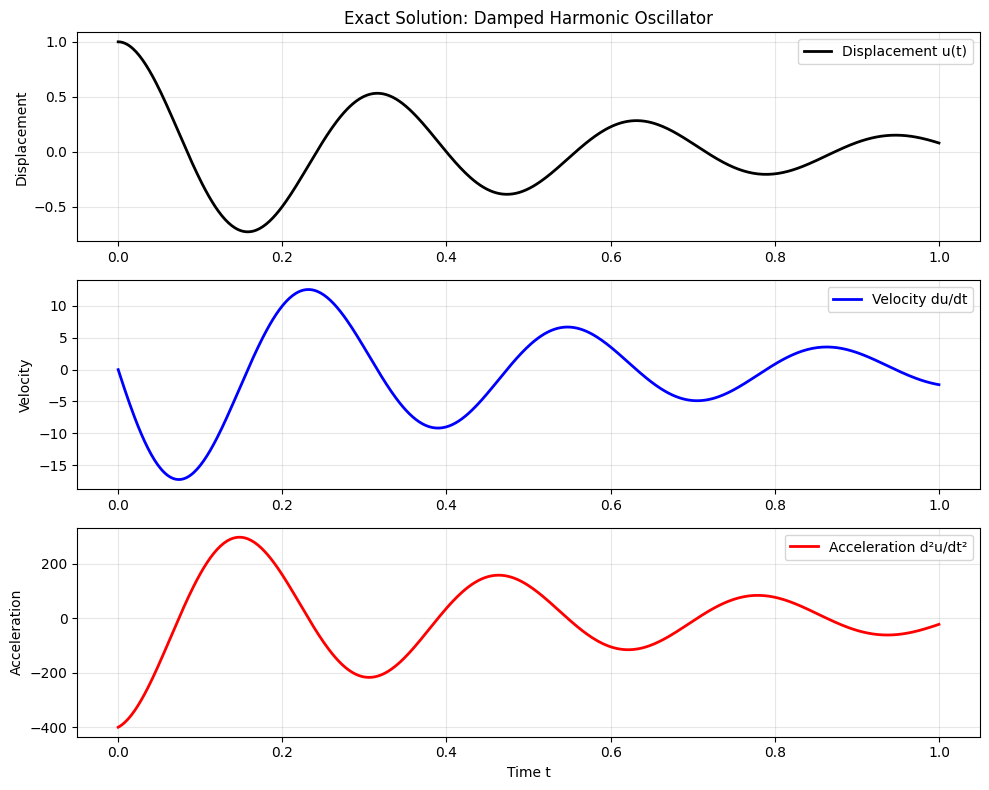

Observe:
• Exponential decay envelope
• Oscillation at damped frequency ω
• Smooth derivatives (critical for neural networks)


In [2]:
def exact_solution(t):
    """Analytical solution to the damped harmonic oscillator"""
    return np.exp(-delta * t) * (np.cos(omega * t) + (delta/omega) * np.sin(omega * t))

def exact_velocity(t):
    """First derivative (velocity)"""
    exp_term = np.exp(-delta * t)
    cos_term = np.cos(omega * t)
    sin_term = np.sin(omega * t)
    
    return exp_term * (-delta * cos_term - omega * sin_term + 
                       (delta/omega) * (-delta * sin_term + omega * cos_term))

def exact_acceleration(t):
    """Second derivative (acceleration)"""
    # From the ODE: a = -(c/m) * v - (k/m) * u
    u = exact_solution(t)
    v = exact_velocity(t)
    return -(c/m) * v - (k/m) * u

# Time domain
t_exact = np.linspace(0, 1, 500)
u_exact = exact_solution(t_exact)
v_exact = exact_velocity(t_exact)
a_exact = exact_acceleration(t_exact)

# Plot the exact solution
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.plot(t_exact, u_exact, 'k-', linewidth=2, label='Displacement u(t)')
ax1.set_ylabel('Displacement')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Exact Solution: Damped Harmonic Oscillator')

ax2.plot(t_exact, v_exact, 'b-', linewidth=2, label='Velocity du/dt')
ax2.set_ylabel('Velocity')
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3.plot(t_exact, a_exact, 'r-', linewidth=2, label='Acceleration d²u/dt²')
ax3.set_ylabel('Acceleration')
ax3.set_xlabel('Time t')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

print("Observe:")
print("• Exponential decay envelope")
print("• Oscillation at damped frequency ω")
print("• Smooth derivatives (critical for neural networks)")

### Creating Sparse Training Data

In real applications, we don't have the complete solution. We only have **sparse, potentially noisy measurements**. Let's simulate this scenario:

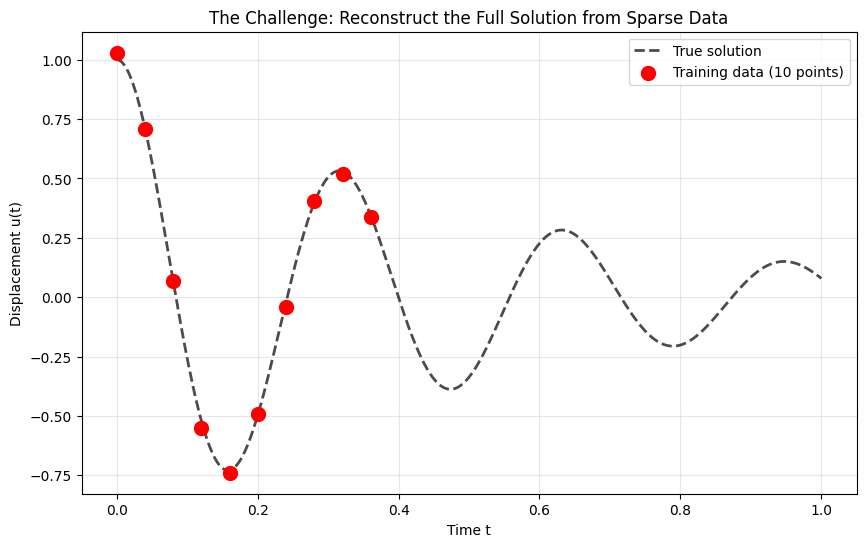

Training data: 10 points with noise level 0.02
Challenge: Can a neural network reconstruct the full solution?


In [23]:
# Generate sparse training data
n_data = 10  # Only 10 data points!
t_data = np.linspace(0, 0.3607, n_data)
u_data = exact_solution(t_data)

# Add some noise to make it realistic
noise_level = 0.02
u_data_noisy = u_data + noise_level * np.random.normal(0, 1, len(u_data))

# Visualize the sparse data
plt.figure(figsize=(10, 6))
plt.plot(t_exact, u_exact, 'k--', linewidth=2, alpha=0.7, label='True solution')
plt.scatter(t_data, u_data_noisy, color='red', s=100, zorder=5, label=f'Training data ({n_data} points)')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.title('The Challenge: Reconstruct the Full Solution from Sparse Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training data: {n_data} points with noise level {noise_level}")
print("Challenge: Can a neural network reconstruct the full solution?")

## Stage 1: The Data-Only Approach (Why It Fails)

**The Natural First Attempt:** Train a neural network to fit the sparse data points.

### Neural Network Architecture

![Standard Neural Network](figs/oscillator-nn.pdf)

A simple feedforward network:
- **Input:** Time $t$
- **Hidden layers:** Dense layers with activation functions
- **Output:** Predicted displacement $\hat{u}_\theta(t)$

**Loss function:** Mean squared error between predictions and data
$$\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N} \sum_{i=1}^N |\hat{u}_\theta(t_i) - u_i|^2$$

**Training:** Standard gradient descent to minimize $\mathcal{L}_{\text{data}}$

In [24]:
class SimpleNN(nn.Module):
    """Standard feedforward neural network"""
    def __init__(self, hidden_size=32, n_layers=3):
        super().__init__()
        
        layers = []
        layers.append(nn.Linear(1, hidden_size))  # Input: time t
        
        # Hidden layers
        for _ in range(n_layers):
            layers.append(nn.Tanh())  # Smooth activation (important!)
            layers.append(nn.Linear(hidden_size, hidden_size))
        
        layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))  # Output: displacement u
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, t):
        return self.network(t)

# Convert data to PyTorch tensors
t_data_tensor = torch.tensor(t_data.reshape(-1, 1), dtype=torch.float32)
u_data_tensor = torch.tensor(u_data_noisy.reshape(-1, 1), dtype=torch.float32)
t_test_tensor = torch.tensor(t_exact.reshape(-1, 1), dtype=torch.float32)

print("Data shapes:")
print(f"  Training: {t_data_tensor.shape} -> {u_data_tensor.shape}")
print(f"  Testing: {t_test_tensor.shape}")

Data shapes:
  Training: torch.Size([10, 1]) -> torch.Size([10, 1])
  Testing: torch.Size([500, 1])


### Training the Standard Neural Network

**What we expect:** The network should learn to pass through the data points.

**What we hope:** It will interpolate smoothly between points.

**What actually happens:** Let's find out!

In [25]:
def train_standard_nn(model, t_data, u_data, epochs=5000, lr=1e-3):
    """Train a standard neural network on data only"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Standard NN"):
        optimizer.zero_grad()
        
        # Forward pass
        u_pred = model(t_data)
        
        # Data loss only
        loss = criterion(u_pred, u_data)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1:4d}: Loss = {loss.item():.6f}")
    
    return losses

# Create and train the standard neural network
standard_nn = SimpleNN()
losses_standard = train_standard_nn(standard_nn, t_data_tensor, u_data_tensor)

print(f"Final training loss: {losses_standard[-1]:.6f}")

Training Standard NN:  30%|██▉       | 1491/5000 [00:00<00:00, 3815.09it/s]

Epoch 1000: Loss = 0.000085


Training Standard NN:  53%|█████▎    | 2658/5000 [00:00<00:00, 3874.75it/s]

Epoch 2000: Loss = 0.000000


Training Standard NN:  69%|██████▉   | 3445/5000 [00:00<00:00, 3903.71it/s]

Epoch 3000: Loss = 0.000000


Training Standard NN:  92%|█████████▏| 4616/5000 [00:01<00:00, 3859.87it/s]

Epoch 4000: Loss = 0.000000


Training Standard NN: 100%|██████████| 5000/5000 [00:01<00:00, 3825.06it/s]

Epoch 5000: Loss = 0.000035
Final training loss: 0.000035


### The Failure of the Data-Only Approach

**Critical Question:** How well does it predict the full solution?

![Standard NN Result](figs/oscillator-result-nn.png)

**What we observe:** The network fits the training points but fails catastrophically between them.

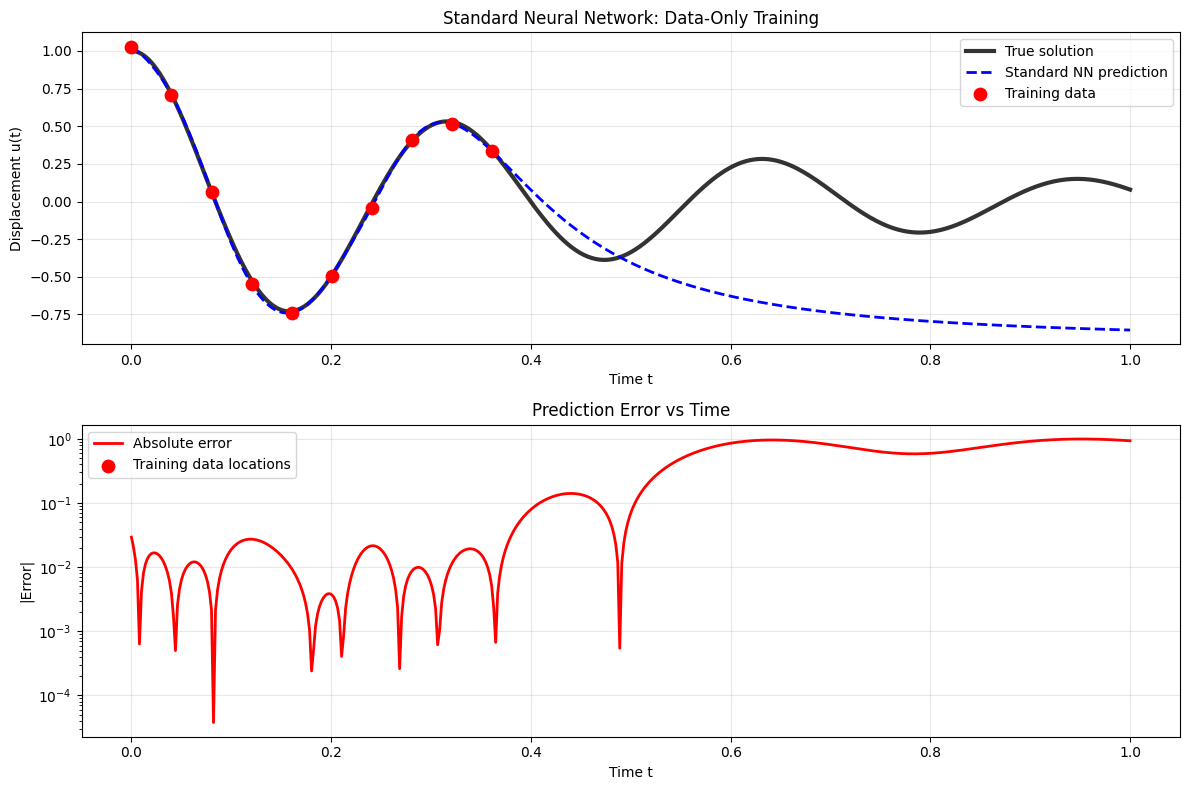

 Standard NN Performance:
  MSE: 0.307095
  Max Error: 0.993746


In [26]:
# Make predictions on the full time domain
with torch.no_grad():
    u_pred_standard = standard_nn(t_test_tensor).numpy().flatten()

# Visualize the results
plt.figure(figsize=(12, 8))

# Plot 1: Full comparison
plt.subplot(2, 1, 1)
plt.plot(t_exact, u_exact, 'k-', linewidth=3, label='True solution', alpha=0.8)
plt.plot(t_exact, u_pred_standard, 'b--', linewidth=2, label='Standard NN prediction')
plt.scatter(t_data, u_data_noisy, color='red', s=80, zorder=5, label='Training data')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.title('Standard Neural Network: Data-Only Training')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error analysis
plt.subplot(2, 1, 2)
error = np.abs(u_pred_standard - u_exact)
plt.plot(t_exact, error, 'r-', linewidth=2, label='Absolute error')
plt.scatter(t_data, np.zeros_like(t_data), color='red', s=80, zorder=5, 
            label='Training data locations')
plt.xlabel('Time t')
plt.ylabel('|Error|')
plt.title('Prediction Error vs Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Compute metrics
mse = np.mean((u_pred_standard - u_exact)**2)
max_error = np.max(np.abs(u_pred_standard - u_exact))

print(f" Standard NN Performance:")
print(f"  MSE: {mse:.6f}")
print(f"  Max Error: {max_error:.6f}")

## Stage 2: Enter Physics-Informed Neural Networks

**The Key Insight:** Instead of just fitting data, enforce the differential equation!

### The PINN Architecture

![PINN Architecture](figs/oscillator-pinn-nn.png)

**Same network, different loss function:**
- Network still predicts $\hat{u}_\theta(t)$
- But now we compute derivatives via **automatic differentiation**
- Physics residual: $\mathcal{R}_\theta(t) = m\frac{d^2\hat{u}_\theta}{dt^2} + c\frac{d\hat{u}_\theta}{dt} + k\hat{u}_\theta$

### The Physics Residual

**Mathematical Foundation:** If $\hat{u}_\theta(t)$ is the exact solution, then:
$$m\frac{d^2\hat{u}_\theta}{dt^2} + c\frac{d\hat{u}_\theta}{dt} + k\hat{u}_\theta = 0$$

**PINN Strategy:** Make this residual as small as possible everywhere in the domain.

**Collocation Points:** We evaluate the residual at many points \{t_j\} throughout $[0,1]$, not just at data points.

### The Complete PINN Loss Function

$$\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{data}}(\theta) + \lambda \mathcal{L}_{\text{physics}}(\theta)$$

where:

**Data Loss:** $\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} |\hat{u}_\theta(t_i) - u_i|^2$

**Physics Loss:** $\mathcal{L}_{\text{physics}}(\theta) = \frac{1}{N_{\text{colloc}}} \sum_{j=1}^{N_{\text{colloc}}} |\mathcal{R}_\theta(t_j)|^2$

**Balance Parameter:** $\lambda$ controls data vs physics trade-off

### Automatic Differentiation: The Secret Weapon

**Critical Question:** How do we compute $\frac{d\hat{u}_\theta}{dt}$ and $\frac{d^2\hat{u}_\theta}{dt^2}$?

**Answer:** Automatic differentiation (AD) gives us **exact** derivatives!

- No finite differences
- No numerical errors
- Computed via chain rule through the computational graph
- Available in PyTorch, TensorFlow, JAX

### Demonstration: Automatic Differentiation in Action

Let's see how automatic differentiation works in PyTorch:

In [27]:
def compute_derivatives_demo():
    """Demonstrate automatic differentiation"""
    # Create a simple test case: u(t) = sin(t)
    t = torch.tensor([0.5], requires_grad=True)  # Enable gradient computation
    u = torch.sin(t)  # u = sin(t)
    
    print("Function: u(t) = sin(t)")
    print(f"At t = {t.item():.2f}:")
    print(f"  u = {u.item():.6f}")
    
    # First derivative: du/dt
    du_dt = torch.autograd.grad(u, t, create_graph=True)[0]
    print(f"  du/dt = {du_dt.item():.6f} (exact: cos({t.item():.2f}) = {np.cos(t.item()):.6f})")
    
    # Second derivative: d²u/dt²
    d2u_dt2 = torch.autograd.grad(du_dt, t, create_graph=True)[0]
    print(f"  d²u/dt² = {d2u_dt2.item():.6f} (exact: -sin({t.item():.2f}) = {-np.sin(t.item()):.6f})")
    
    print("✅ Automatic differentiation gives exact derivatives!")

compute_derivatives_demo()

Function: u(t) = sin(t)
At t = 0.50:
  u = 0.479426
  du/dt = 0.877583 (exact: cos(0.50) = 0.877583)
  d²u/dt² = -0.479426 (exact: -sin(0.50) = -0.479426)
✅ Automatic differentiation gives exact derivatives!


## Stage 3: PINN Implementation

**Now the real work begins!** Let's implement a Physics-Informed Neural Network step by step.

### Step 1: Physics Loss Function

The heart of PINN is computing the physics residual using automatic differentiation:

In [28]:
def physics_loss(model, t_colloc, m, c, k):
    """
    Compute the physics loss for the damped harmonic oscillator
    
    ODE: m * d²u/dt² + c * du/dt + k * u = 0
    """
    # Ensure gradients are enabled for input
    t_colloc = t_colloc.clone().detach().requires_grad_(True)
    
    # Forward pass: compute u(t)
    u = model(t_colloc)
    
    # First derivative: du/dt
    du_dt = torch.autograd.grad(
        outputs=u, 
        inputs=t_colloc,
        grad_outputs=torch.ones_like(u),
        create_graph=True,  # Allow higher-order derivatives
        retain_graph=True
    )[0]
    
    # Second derivative: d²u/dt²
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_colloc,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Physics residual: R = m * d²u/dt² + c * du/dt + k * u
    residual = m * d2u_dt2 + c * du_dt + k * u
    
    # Mean squared residual
    physics_loss = torch.mean(residual**2)
    
    return physics_loss

# Test the physics loss function
test_model = SimpleNN()
t_test_colloc = torch.linspace(0, 1, 50).reshape(-1, 1)
test_loss = physics_loss(test_model, t_test_colloc, m, c, k)

print(f"Physics loss (untrained model): {test_loss.item():.6f}")
print("This is large since the model hasn't learned the physics yet!")

Physics loss (untrained model): 144.952454
This is large since the model hasn't learned the physics yet!


### Step 2: Complete PINN Training Loop

**Key Components:**
1. **Data loss:** Fit the sparse measurements
2. **Physics loss:** Satisfy the differential equation
3. **Collocation points:** Where we enforce physics (not necessarily data points)
4. **Balance parameter $\lambda$:** Controls the trade-off

Collocation points: uniformly distributed in [0, 1]
Physics weight λ = 0.0001 (typically much smaller than 1)


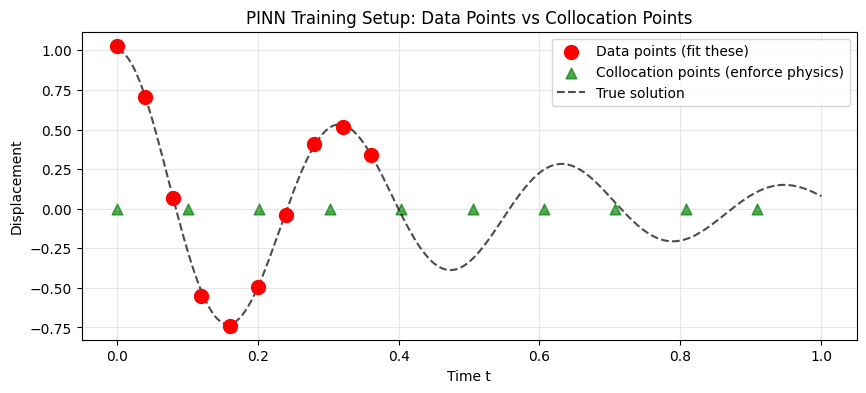

In [29]:
def train_pinn(model, t_data, u_data, t_colloc, m, c, k, 
               epochs=10000, lr=1e-3, lambda_physics=1e-4):
    """
    Train a Physics-Informed Neural Network
    
    Args:
        model: Neural network
        t_data, u_data: Training data points
        t_colloc: Collocation points for physics
        m, c, k: Physical parameters
        lambda_physics: Balance parameter between data and physics
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Storage for loss history
    data_losses = []
    physics_losses = []
    total_losses = []
    
    print(f"Training PINN with λ = {lambda_physics}")
    print(f"Data points: {len(t_data)}, Collocation points: {len(t_colloc)}")
    
    for epoch in tqdm(range(epochs), desc="Training PINN"):
        optimizer.zero_grad()
        
        # Data loss: how well do we fit the measurements?
        u_pred_data = model(t_data)
        loss_data = criterion(u_pred_data, u_data)
        
        # Physics loss: how well do we satisfy the ODE?
        loss_physics = physics_loss(model, t_colloc, m, c, k)
        
        # Total loss: balance data fitting and physics
        total_loss = loss_data + lambda_physics * loss_physics
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        # Store losses
        data_losses.append(loss_data.item())
        physics_losses.append(loss_physics.item())
        total_losses.append(total_loss.item())
        
        if (epoch + 1) % 2000 == 0:
            print(f"Epoch {epoch+1:5d}: Data={loss_data.item():.6f}, "
                  f"Physics={loss_physics.item():.6f}, Total={total_loss.item():.6f}")
    
    return data_losses, physics_losses, total_losses

# Setup for PINN training
n_colloc = 100  # Number of collocation points
t_colloc = torch.linspace(0, 1, n_colloc).reshape(-1, 1)
lambda_physics = 1e-4  # Balance parameter

print(f"Collocation points: uniformly distributed in [0, 1]")
print(f"Physics weight λ = {lambda_physics} (typically much smaller than 1)")

# Visualize training setup
plt.figure(figsize=(10, 4))
plt.scatter(t_data, u_data_noisy, color='red', s=100, zorder=5, label='Data points (fit these)')
plt.scatter(t_colloc.numpy().flatten()[::10], np.zeros(len(t_colloc[::10])), 
            color='green', marker='^', s=60, alpha=0.7, label='Collocation points (enforce physics)')
plt.plot(t_exact, u_exact, 'k--', alpha=0.7, label='True solution')
plt.xlabel('Time t')
plt.ylabel('Displacement')
plt.title('PINN Training Setup: Data Points vs Collocation Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 3: Train the PINN

**The moment of truth!** Let's train the PINN and see if it can learn both the data and the physics:

In [30]:
# Create a fresh PINN model
pinn_model = SimpleNN()

# Train the PINN
data_losses, physics_losses, total_losses = train_pinn(
    pinn_model, t_data_tensor, u_data_tensor, t_colloc, m, c, k
)

# Make predictions
with torch.no_grad():
    u_pred_pinn = pinn_model(t_test_tensor).numpy().flatten()

print(f"PINN Training Complete!")
print(f"Final data loss: {data_losses[-1]:.6f}")
print(f"Final physics loss: {physics_losses[-1]:.6f}")

Training PINN with λ = 0.0001
Data points: 10, Collocation points: 100


Training PINN:  21%|██        | 2096/10000 [00:02<00:09, 842.18it/s]

Epoch  2000: Data=0.006123, Physics=296.414642, Total=0.035764


Training PINN:  42%|████▏     | 4159/10000 [00:04<00:06, 842.86it/s]

Epoch  4000: Data=0.001982, Physics=195.233521, Total=0.021505


Training PINN:  61%|██████▏   | 6130/10000 [00:07<00:04, 856.06it/s]

Epoch  6000: Data=0.000474, Physics=89.163933, Total=0.009391


Training PINN:  82%|████████▏ | 8164/10000 [00:09<00:02, 847.83it/s]

Epoch  8000: Data=0.000387, Physics=78.075439, Total=0.008194


Training PINN: 100%|██████████| 10000/10000 [00:11<00:00, 839.25it/s]

Epoch 10000: Data=0.000249, Physics=45.839497, Total=0.004833
PINN Training Complete!
Final data loss: 0.000249
Final physics loss: 45.839497


## Stage 4: The Moment of Truth - Comparing Results

### Direct Comparison: Standard NN vs PINN

![PINN Result](figs/oscillator-result-pinn.png)

**What we expect to see:**
- **Standard NN:** Fits data points but fails between them
- **PINN:** Fits data points AND follows physics everywhere

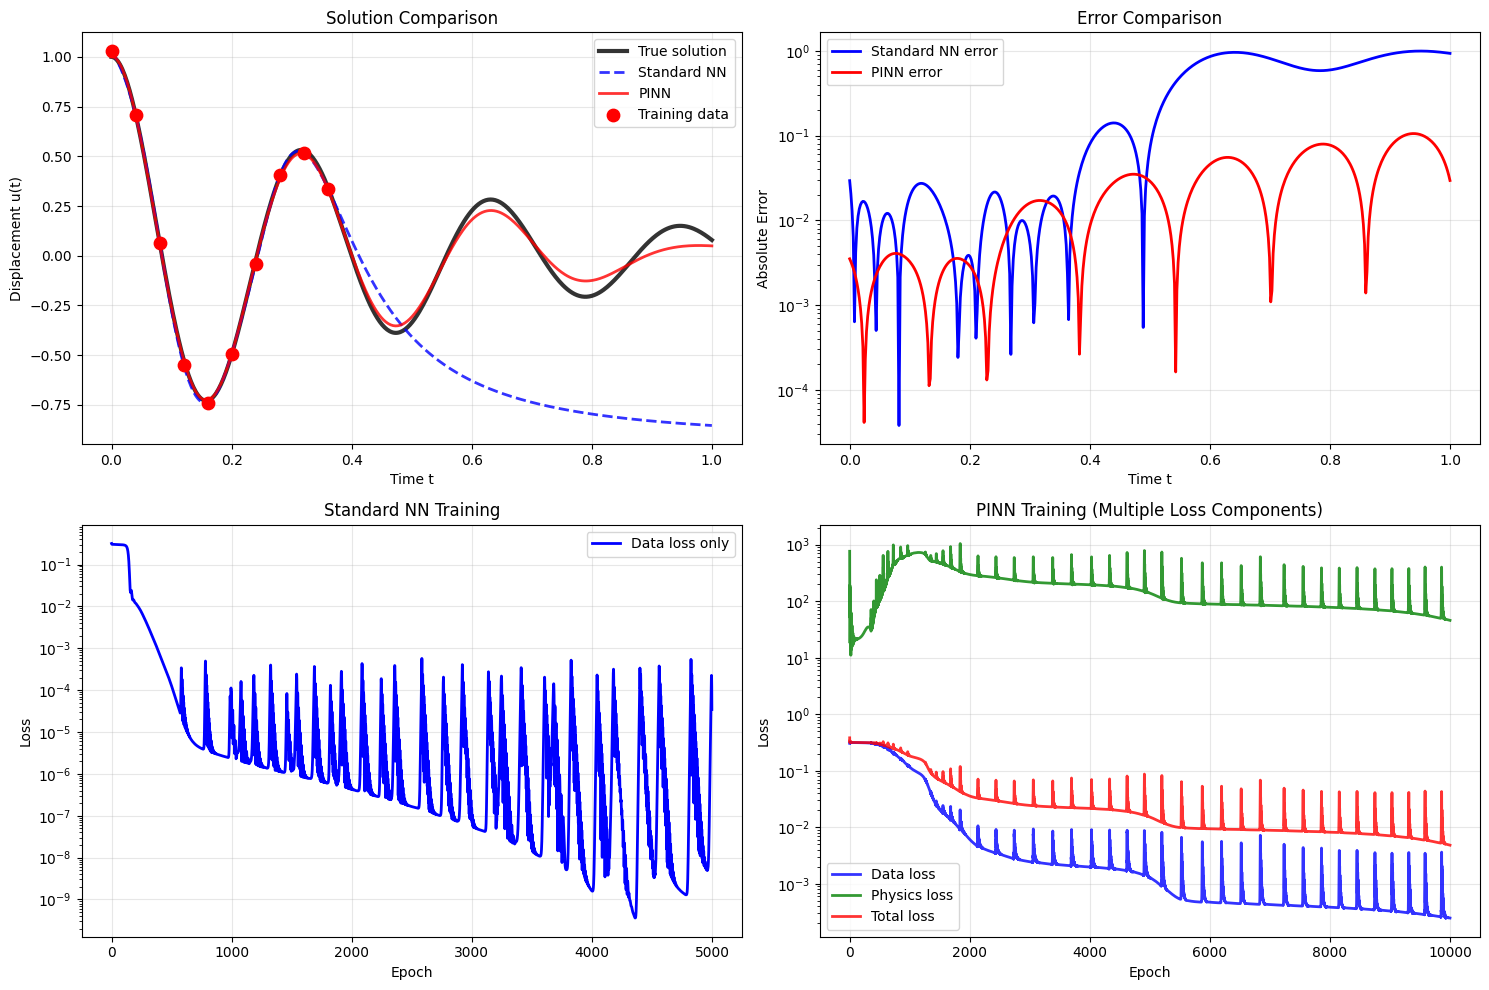

📊 QUANTITATIVE COMPARISON
Metric               Standard NN     PINN            Improvement    
-----------------------------------------------------------------
MSE                  0.307095        0.001684        182.3          x
Max Error            0.993746        0.105617        9.4            x
✅ PINN is 182x more accurate!


In [31]:
# Compare Standard NN vs PINN
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Solutions comparison
ax = axes[0, 0]
ax.plot(t_exact, u_exact, 'k-', linewidth=3, label='True solution', alpha=0.8)
ax.plot(t_exact, u_pred_standard, 'b--', linewidth=2, label='Standard NN', alpha=0.8)
ax.plot(t_exact, u_pred_pinn, 'r-', linewidth=2, label='PINN', alpha=0.8)
ax.scatter(t_data, u_data_noisy, color='red', s=80, zorder=5, label='Training data')
ax.set_xlabel('Time t')
ax.set_ylabel('Displacement u(t)')
ax.set_title('Solution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Error comparison
ax = axes[0, 1]
error_standard = np.abs(u_pred_standard - u_exact)
error_pinn = np.abs(u_pred_pinn - u_exact)
ax.plot(t_exact, error_standard, 'b-', linewidth=2, label='Standard NN error')
ax.plot(t_exact, error_pinn, 'r-', linewidth=2, label='PINN error')
ax.set_xlabel('Time t')
ax.set_ylabel('Absolute Error')
ax.set_title('Error Comparison')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Loss evolution for Standard NN
ax = axes[1, 0]
ax.plot(losses_standard, 'b-', linewidth=2, label='Data loss only')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Standard NN Training')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Loss evolution for PINN
ax = axes[1, 1]
ax.plot(data_losses, 'b-', linewidth=2, label='Data loss', alpha=0.8)
ax.plot(physics_losses, 'g-', linewidth=2, label='Physics loss', alpha=0.8)
ax.plot(total_losses, 'r-', linewidth=2, label='Total loss', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('PINN Training (Multiple Loss Components)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative comparison
mse_standard = np.mean((u_pred_standard - u_exact)**2)
mse_pinn = np.mean((u_pred_pinn - u_exact)**2)
max_error_standard = np.max(np.abs(u_pred_standard - u_exact))
max_error_pinn = np.max(np.abs(u_pred_pinn - u_exact))

print("📊 QUANTITATIVE COMPARISON")
print("="*50)
print(f"{'Metric':<20} {'Standard NN':<15} {'PINN':<15} {'Improvement':<15}")
print("-"*65)
print(f"{'MSE':<20} {mse_standard:<15.6f} {mse_pinn:<15.6f} {mse_standard/mse_pinn:<15.1f}x")
print(f"{'Max Error':<20} {max_error_standard:<15.6f} {max_error_pinn:<15.6f} {max_error_standard/max_error_pinn:<15.1f}x")

print(f"✅ PINN is {mse_standard/mse_pinn:.0f}x more accurate!")

### Deep Dive: Derivative Analysis

**Critical Test:** Can the PINN learn physically consistent derivatives?

Since we enforce the ODE through derivatives, the PINN should naturally learn correct $\frac{du}{dt}$ and $\frac{d^2u}{dt^2}$.

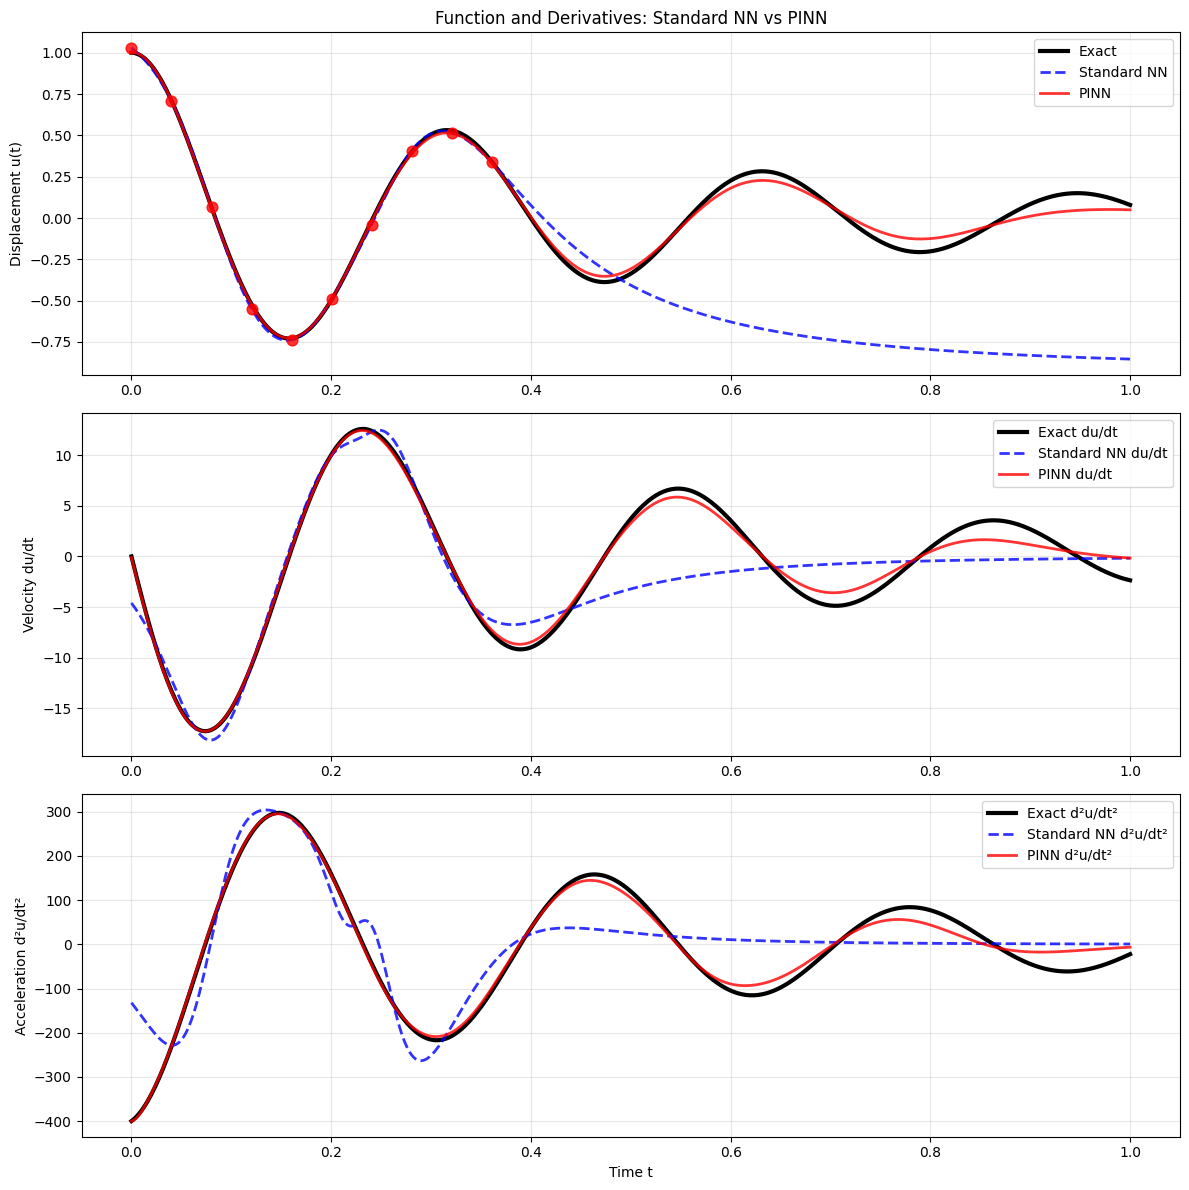

📈 DERIVATIVE ACCURACY
Velocity MSE (du/dt):
  Standard NN: 10.786616
  PINN: 0.637307
  Improvement: 16.9x
Acceleration MSE (d²u/dt²):
  Standard NN: 4985.118844
  PINN: 302.882951
  Improvement: 16.5x


In [33]:
def compute_model_derivatives(model, t_tensor):
    """Compute derivatives of the model using automatic differentiation"""
    t_tensor = t_tensor.clone().detach().requires_grad_(True)
    
    # Function value
    u = model(t_tensor)
    
    # First derivative
    du_dt = torch.autograd.grad(u, t_tensor, grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True)[0]
    
    # Second derivative
    d2u_dt2 = torch.autograd.grad(du_dt, t_tensor, grad_outputs=torch.ones_like(du_dt),
                                 create_graph=True, retain_graph=True)[0]
    
    return u.detach().numpy(), du_dt.detach().numpy(), d2u_dt2.detach().numpy()

# Compute derivatives for both models
# REMOVED torch.no_grad() context - this was causing the error
# Standard NN derivatives
u_std, du_dt_std, d2u_dt2_std = compute_model_derivatives(standard_nn, t_test_tensor)

# PINN derivatives
u_pinn, du_dt_pinn, d2u_dt2_pinn = compute_model_derivatives(pinn_model, t_test_tensor)

# Analytical derivatives for comparison
v_exact = exact_velocity(t_exact)
a_exact = exact_acceleration(t_exact)

# Plot derivative comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Displacement
ax = axes[0]
ax.plot(t_exact, u_exact, 'k-', linewidth=3, label='Exact')
ax.plot(t_exact, u_std.flatten(), 'b--', linewidth=2, label='Standard NN', alpha=0.8)
ax.plot(t_exact, u_pinn.flatten(), 'r-', linewidth=2, label='PINN', alpha=0.8)
ax.scatter(t_data, u_data_noisy, color='red', s=60, zorder=5, alpha=0.8)
ax.set_ylabel('Displacement u(t)')
ax.set_title('Function and Derivatives: Standard NN vs PINN')
ax.legend()
ax.grid(True, alpha=0.3)

# First derivative (velocity)
ax = axes[1]
ax.plot(t_exact, v_exact, 'k-', linewidth=3, label='Exact du/dt')
ax.plot(t_exact, du_dt_std.flatten(), 'b--', linewidth=2, label='Standard NN du/dt', alpha=0.8)
ax.plot(t_exact, du_dt_pinn.flatten(), 'r-', linewidth=2, label='PINN du/dt', alpha=0.8)
ax.set_ylabel('Velocity du/dt')
ax.legend()
ax.grid(True, alpha=0.3)

# Second derivative (acceleration)
ax = axes[2]
ax.plot(t_exact, a_exact, 'k-', linewidth=3, label='Exact d²u/dt²')
ax.plot(t_exact, d2u_dt2_std.flatten(), 'b--', linewidth=2, label='Standard NN d²u/dt²', alpha=0.8)
ax.plot(t_exact, d2u_dt2_pinn.flatten(), 'r-', linewidth=2, label='PINN d²u/dt²', alpha=0.8)
ax.set_ylabel('Acceleration d²u/dt²')
ax.set_xlabel('Time t')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Derivative errors
print("📈 DERIVATIVE ACCURACY")
print("="*40)

velocity_error_std = np.mean((du_dt_std.flatten() - v_exact)**2)
velocity_error_pinn = np.mean((du_dt_pinn.flatten() - v_exact)**2)
accel_error_std = np.mean((d2u_dt2_std.flatten() - a_exact)**2)
accel_error_pinn = np.mean((d2u_dt2_pinn.flatten() - a_exact)**2)

print(f"Velocity MSE (du/dt):")
print(f"  Standard NN: {velocity_error_std:.6f}")
print(f"  PINN: {velocity_error_pinn:.6f}")
print(f"  Improvement: {velocity_error_std/velocity_error_pinn:.1f}x")

print(f"Acceleration MSE (d²u/dt²):")
print(f"  Standard NN: {accel_error_std:.6f}")
print(f"  PINN: {accel_error_pinn:.6f}")
print(f"  Improvement: {accel_error_std/accel_error_pinn:.1f}x")

## Summary: Why PINNs Work

### The Revolutionary Insight

**Traditional ML:** Learn patterns from data alone

**PINNs:** Learn patterns from data AND physics simultaneously

### Key Advantages of PINNs

1. **Regularization Effect:** Physics constraints prevent overfitting
    - Standard NN can fit any function through the data points
    - PINN is constrained to solutions that satisfy the ODE

2. **Better Interpolation:** Smooth, physically meaningful predictions between data points
    - Standard NN: arbitrary interpolation
    - PINN: physics-guided interpolation

3. **Accurate Derivatives:** Natural consequence of physics enforcement
    - Automatic differentiation + physics loss = correct derivatives
    - Critical for applications requiring gradients (optimization, control)

4. **Data Efficiency:** Less training data needed
    - Physics provides strong inductive bias
    - Can generalize from very sparse measurements

### The Universal Approximation Foundation

**Why this works theoretically:**
- Neural networks can approximate functions in Sobolev spaces $H^k$
- Sobolev spaces include both functions AND their derivatives
- With smooth activation functions ($\tanh$, $\sin$), we can approximate solutions to differential equations
- Automatic differentiation makes this practical

### When to Use PINNs

**Ideal scenarios:**
- ✅ Known governing equations (PDEs/ODEs)
- ✅ Sparse, noisy data
- ✅ Need physically consistent solutions
- ✅ Require accurate derivatives
- ✅ Complex geometries (where finite elements struggle)

**Limitations:**
- ❌ Unknown physics
- ❌ Highly nonlinear/chaotic systems
- ❌ Large-scale problems (computational cost)
- ❌ Discontinuous solutions

### Extensions and Applications

**This framework extends to:**
- **Partial Differential Equations:** Heat equation, wave equation, Navier-Stokes
- **Inverse Problems:** Estimate unknown parameters from data
- **Multi-physics:** Coupled systems (fluid-structure interaction)
- **High Dimensions:** Curse of dimensionality breaking

### The Bottom Line

**PINNs = Universal Function Approximation + Physics Constraints + Automatic Differentiation**

This combination creates a powerful method for solving differential equations with neural networks, particularly when data is sparse and physics is well-understood.

---

**Next Steps:** Try this approach on the 1D Poisson equation with hard constraints!